# Classification Modeling

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import re
from numpy.random import normal
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from six import StringIO 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from IPython.display import Image
import pydotplus
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read modeling data and drop unnecessary columns 
data = pd.read_csv('modelingdata')
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
#Look at the info from the dataframe 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7031 entries, 0 to 7030
Data columns (total 39 columns):
artist              7031 non-null object
artist_id           7031 non-null object
album               7031 non-null object
track_name          7031 non-null object
is_explicit         7031 non-null int64
track_id            7031 non-null object
danceability        7031 non-null float64
energy              7031 non-null float64
key                 7031 non-null int64
loudness            7031 non-null float64
mode                7031 non-null int64
speechiness         7031 non-null float64
acousticness        7031 non-null float64
instrumentalness    7031 non-null float64
liveness            7031 non-null float64
valence             7031 non-null float64
tempo               7031 non-null float64
duration_ms         7031 non-null int64
ratings             7031 non-null int64
decade_1960         7031 non-null int64
decade_1970         7031 non-null int64
decade_1980         7031 non-n

In [4]:
#Drop columns that are not relevant to classification analysis 
songs = data.drop(['genrecategory', 'track_id', 'artist_id', 'track_name', 'artist', 'album'], axis=1)

## Functions

In [5]:
#Define a function that fits and predicts our data 

def model_fit(trainx, trainy, testx, testy, model, name):  
    #Fit X_train and Y_train 
    model.fit(trainx, trainy)

    #Predict on the test set 
    test_prediction = model.predict(testx)
    #Predict on the train set 
    train_prediction = model.predict(trainx)
    
    #Create a dictionary of the results starting with the model's name 
    result = {'model': name}
    
    #Calculate and append train result metrics to the 'result' dictionary 
    result['train_accuracy'] = np.around((accuracy_score(trainy, train_prediction)), decimals=3)
    result['train_precision'] = np.around((precision_score(trainy, train_prediction, average='micro')), decimals=3)
    result['train_recall'] = np.around((recall_score(trainy, train_prediction, average='micro')), decimals=3)
    result['train_f1'] = np.around((f1_score(trainy, train_prediction, average='micro')), decimals=3)
    
    #Calculate and append test result metrics to the 'result' dictionary 
    result['test_accuracy'] = np.around((accuracy_score(testy, test_prediction)), decimals=3)
    result['test_precision'] = np.around((precision_score(testy, test_prediction, average='micro')), decimals=3)
    result['test_recall'] = np.around((recall_score(testy, test_prediction, average='micro')), decimals=3)
    result['test_f1'] = np.around((f1_score(testy, test_prediction, average='micro')), decimals=3)
    
    print("\n")
    
    #Print the classification report for the train results 
    print("Train Score Results")
    print(classification_report(trainy, train_prediction))
    #Print the accuracy, precision, recall and f1 score for train set 
    print("Train Set Accuracy:", result['train_accuracy'])
    print("Train Set Precision:", result['train_precision'])
    print("Train Set Recall:", result['train_recall'])
    print("Train Set F1-Score:", result['train_f1'])

    print("\n")
    
    #Print the classification report for the test results
    print("Test Score Results")    
    print(classification_report(testy, test_prediction)) 
    #Print the accuracy, precision, recall and f1 score for test set                                   
    print("Test Set Accuracy:", result['test_accuracy'])  
    print("Test Set Precision:", result['test_precision']) 
    print("Test Set Recall:", result['test_recall'])
    print("Test Set F1-Score:", result['test_f1'])
                                      
    
    print("\n")
    
   
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    #Plot the train confusion matrix 
    trainmatrix = plot_confusion_matrix(model, trainx, trainy, cmap=plt.cm.Blues, ax=ax1)
    #Plot the test confusion matrix 
    testmatrix = plot_confusion_matrix(model, testx, testy, cmap=plt.cm.Blues, ax=ax2)
    #Set titles for the plot 
    ax1.set_title('Train Confusion Matrix')
    ax2.set_title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return result

In [6]:
#Create function for plotting a feature importance histogram 
def features_plot(df, title):
    df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = df, orient = 'h', color = 'blue') \
       .set_title(title, fontsize = 20)

In [7]:
#Create function for creating a feature importance dataframe
def features_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

## Train Test Split

In [8]:
#Explore the class distribution of the target variable "ratings"
songs['ratings'].value_counts()

3    2659
2    1898
4    1325
1     891
5     258
Name: ratings, dtype: int64

In [9]:
#Set X and y values 
y = songs['ratings']
X = songs.drop(['ratings'], axis=1)

In [10]:
#Investigate the value counts of our target variable 
y.value_counts(normalize=True)

3    0.378182
2    0.269947
4    0.188451
1    0.126725
5    0.036695
Name: ratings, dtype: float64

In [11]:
#Perform train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Section A: Vanilla Models

Before I tune any models, I will perform basic vanilla models on serveral machine learning models in order to determine which perform the best. The aim of these models is to optimize precision in order to ensure that each classification is classified properly; therefore I will later decide which models to tune further, depending on which vanilla models yield the strongest test_precision results.

### 1. KNN Model

In [12]:
#Scale the data
scaler = StandardScaler()  
scaler.fit(X_train)

#Scale original X_train and X_test
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

In [13]:
#Fit and predict the vanilla KNN model
knnmodel = KNeighborsClassifier()



Train Score Results
              precision    recall  f1-score   support

           1       0.48      0.47      0.48       667
           2       0.53      0.64      0.58      1413
           3       0.59      0.66      0.62      1991
           4       0.59      0.39      0.47      1009
           5       0.42      0.06      0.10       193

    accuracy                           0.56      5273
   macro avg       0.52      0.44      0.45      5273
weighted avg       0.55      0.56      0.54      5273

Train Set Accuracy: 0.556
Train Set Precision: 0.556
Train Set Recall: 0.556
Train Set F1-Score: 0.556


Test Score Results
              precision    recall  f1-score   support

           1       0.19      0.18      0.19       224
           2       0.34      0.40      0.37       485
           3       0.40      0.44      0.42       668
           4       0.32      0.22      0.26       316
           5       0.00      0.00      0.00        65

    accuracy                           

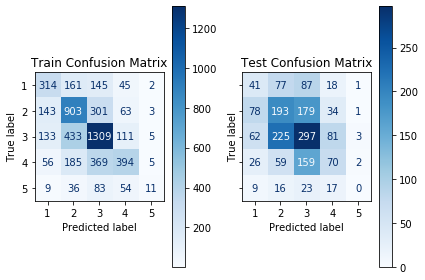

In [14]:
#Apply the model and print metrics
knnresult = model_fit(X_train_scaled, y_train, X_test_scaled, y_test, knnmodel, 'knn')

### 2. Bayes Classification Model

In [15]:
#Instansiate the vanilla bayes model
bayes = GaussianNB()



Train Score Results
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       667
           2       0.33      0.00      0.01      1413
           3       0.38      0.98      0.55      1991
           4       0.27      0.02      0.04      1009
           5       0.00      0.00      0.00       193

    accuracy                           0.38      5273
   macro avg       0.20      0.20      0.12      5273
weighted avg       0.28      0.38      0.21      5273

Train Set Accuracy: 0.376
Train Set Precision: 0.376
Train Set Recall: 0.376
Train Set F1-Score: 0.376


Test Score Results
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       224
           2       0.25      0.00      0.00       485
           3       0.38      0.98      0.54       668
           4       0.24      0.02      0.03       316
           5       0.00      0.00      0.00        65

    accuracy                           

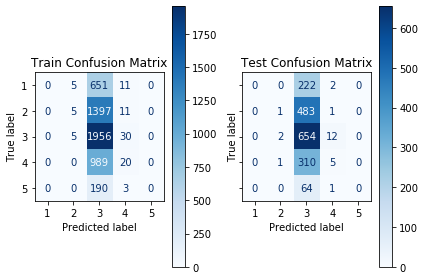

In [16]:
#Apply the model_fit function
bayesresult = model_fit(X_train, y_train, X_test, y_test, bayes, 'bayes')

### 3. Decision Tree Classifier

In [17]:
#Instansiate the vanilla decision tree model 
decisiontree = DecisionTreeClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       667
           2       0.99      1.00      1.00      1413
           3       1.00      0.99      1.00      1991
           4       1.00      0.99      1.00      1009
           5       1.00      0.98      0.99       193

    accuracy                           1.00      5273
   macro avg       1.00      0.99      0.99      5273
weighted avg       1.00      1.00      1.00      5273

Train Set Accuracy: 0.995
Train Set Precision: 0.995
Train Set Recall: 0.995
Train Set F1-Score: 0.995


Test Score Results
              precision    recall  f1-score   support

           1       0.14      0.13      0.14       224
           2       0.37      0.37      0.37       485
           3       0.42      0.39      0.40       668
           4       0.25      0.28      0.26       316
           5       0.06      0.08      0.07        65

    accuracy                           

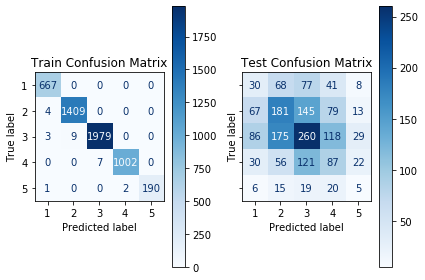

In [18]:
#Apply the model fit function 
decisiontreeresult = model_fit(X_train, y_train, X_test, y_test, decisiontree, 'decisiontree')

In [19]:
#Look at feature importances of our decision tree 
features = features_df(X_train.columns, decisiontree.feature_importances_)
features

,feature,feature_importance
0,liveness,0.097675
1,speechiness,0.096575
2,valence,0.094611
3,duration_ms,0.093643
4,tempo,0.090589
5,danceability,0.080370
6,loudness,0.080268
7,energy,0.075454
8,acousticness,0.067648
9,instrumentalness,0.063885


### 4. Ensemble Methods

#### a. Bagging Method

In [20]:
#Instansiate the bagged method vanilla model
bagged_tree = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=20)



Train Score Results
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       667
           2       0.99      1.00      0.99      1413
           3       0.99      0.99      0.99      1991
           4       1.00      0.99      0.99      1009
           5       0.99      0.98      0.99       193

    accuracy                           0.99      5273
   macro avg       0.99      0.99      0.99      5273
weighted avg       0.99      0.99      0.99      5273

Train Set Accuracy: 0.994
Train Set Precision: 0.994
Train Set Recall: 0.994
Train Set F1-Score: 0.994


Test Score Results
              precision    recall  f1-score   support

           1       0.14      0.06      0.08       224
           2       0.35      0.37      0.36       485
           3       0.41      0.56      0.47       668
           4       0.38      0.27      0.31       316
           5       0.14      0.02      0.03        65

    accuracy                           

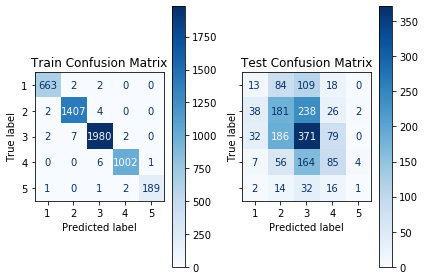

In [21]:
#Apply the model prediction
baggingresult = model_fit(X_train, y_train, X_test, y_test, bagged_tree, 'bagging')

#### b. Random Forest Classifier

In [22]:
#Instansiate the random forest vanilla model 
randomforest = RandomForestClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       667
           2       1.00      1.00      1.00      1413
           3       0.99      1.00      1.00      1991
           4       1.00      1.00      1.00      1009
           5       1.00      0.98      0.99       193

    accuracy                           1.00      5273
   macro avg       1.00      0.99      0.99      5273
weighted avg       1.00      1.00      1.00      5273

Train Set Accuracy: 0.995
Train Set Precision: 0.995
Train Set Recall: 0.995
Train Set F1-Score: 0.995


Test Score Results
              precision    recall  f1-score   support

           1       0.25      0.03      0.05       224
           2       0.40      0.38      0.39       485
           3       0.41      0.67      0.51       668
           4       0.39      0.24      0.30       316
           5       0.17      0.02      0.03        65

    accuracy                           

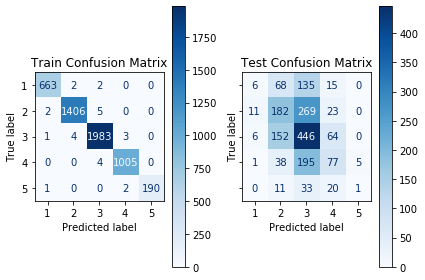

In [23]:
#Apply the model_fit function 
randomforestresult = model_fit(X_train, y_train, X_test, y_test, randomforest, 'randomforest')

In [24]:
#Look at another performance measure: mean 3-Fold cross validation score 
mean_rf_cv_score = np.mean(cross_val_score(randomforest, X_train, y_train, cv=3))
mean_rf_cv_score

0.4039459476142777

## 5. Boosting

### a. Adaboost

In [25]:
#Instansiate the Adaboost vanilla model
adb = AdaBoostClassifier(random_state=0)



Train Score Results
              precision    recall  f1-score   support

           1       0.32      0.03      0.06       667
           2       0.41      0.21      0.28      1413
           3       0.40      0.80      0.53      1991
           4       0.47      0.23      0.31      1009
           5       0.13      0.02      0.04       193

    accuracy                           0.41      5273
   macro avg       0.35      0.26      0.24      5273
weighted avg       0.40      0.41      0.35      5273

Train Set Accuracy: 0.407
Train Set Precision: 0.407
Train Set Recall: 0.407
Train Set F1-Score: 0.407


Test Score Results
              precision    recall  f1-score   support

           1       0.25      0.02      0.03       224
           2       0.43      0.24      0.30       485
           3       0.40      0.77      0.52       668
           4       0.41      0.20      0.27       316
           5       0.00      0.00      0.00        65

    accuracy                           

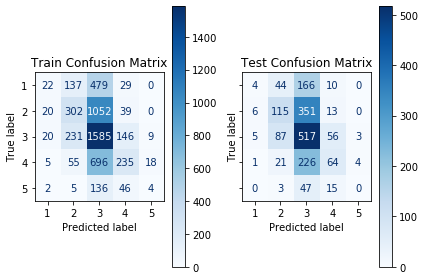

In [26]:
#Fit and predict model and show results
adbresult = model_fit(X_train, y_train, X_test, y_test, adb, 'Adaboost')



Train Score Results
              precision    recall  f1-score   support

           1       0.32      0.03      0.06       667
           2       0.41      0.21      0.28      1413
           3       0.40      0.80      0.53      1991
           4       0.47      0.23      0.31      1009
           5       0.13      0.02      0.04       193

    accuracy                           0.41      5273
   macro avg       0.35      0.26      0.24      5273
weighted avg       0.40      0.41      0.35      5273

Train Set Accuracy: 0.407
Train Set Precision: 0.407
Train Set Recall: 0.407
Train Set F1-Score: 0.407


Test Score Results
              precision    recall  f1-score   support

           1       0.25      0.02      0.03       224
           2       0.43      0.24      0.30       485
           3       0.40      0.77      0.52       668
           4       0.41      0.20      0.27       316
           5       0.00      0.00      0.00        65

    accuracy                           

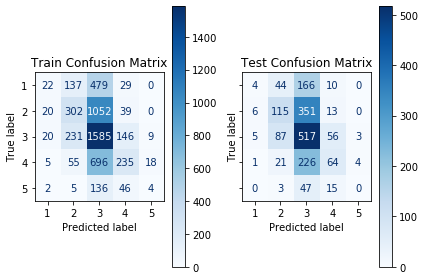

In [27]:
#Fit and predict model and show results
adbresult = model_fit(X_train, y_train, X_test, y_test, adb, 'Adaboost')

### b. Gradient Boosting

In [28]:
#Instansiate the Gradient Boosting vanilla model
gb = GradientBoostingClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           1       0.93      0.13      0.23       667
           2       0.62      0.45      0.52      1413
           3       0.49      0.87      0.63      1991
           4       0.74      0.37      0.49      1009
           5       1.00      0.31      0.47       193

    accuracy                           0.55      5273
   macro avg       0.75      0.43      0.47      5273
weighted avg       0.65      0.55      0.52      5273

Train Set Accuracy: 0.551
Train Set Precision: 0.551
Train Set Recall: 0.551
Train Set F1-Score: 0.551


Test Score Results
              precision    recall  f1-score   support

           1       0.17      0.02      0.03       224
           2       0.43      0.30      0.36       485
           3       0.40      0.74      0.52       668
           4       0.39      0.21      0.27       316
           5       0.00      0.00      0.00        65

    accuracy                           

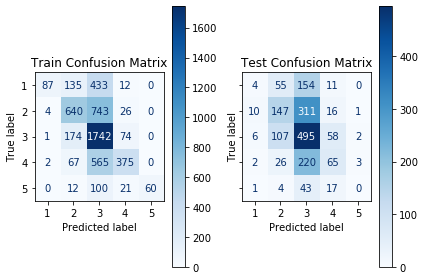

In [29]:
#Fit and predict model and show results
gbresult = model_fit(X_train, y_train, X_test, y_test, gb, 'Gradient_Boosting')

In [30]:
#Look at another performance measure: mean 3-Fold cross validation score 
gb_mean_cv = cross_val_score(gb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {gb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  36.41%


### c. XGBoost

In [31]:
#Instansiate the XGBoost vanilla model
xgb = XGBClassifier(random_state=0)



Train Score Results
              precision    recall  f1-score   support

           1       1.00      0.04      0.08       667
           2       0.57      0.37      0.45      1413
           3       0.45      0.87      0.59      1991
           4       0.65      0.30      0.41      1009
           5       1.00      0.03      0.05       193

    accuracy                           0.49      5273
   macro avg       0.73      0.32      0.31      5273
weighted avg       0.61      0.49      0.43      5273

Train Set Accuracy: 0.49
Train Set Precision: 0.49
Train Set Recall: 0.49
Train Set F1-Score: 0.49


Test Score Results
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       224
           2       0.44      0.27      0.34       485
           3       0.40      0.79      0.53       668
           4       0.43      0.18      0.25       316
           5       0.00      0.00      0.00        65

    accuracy                           0.41

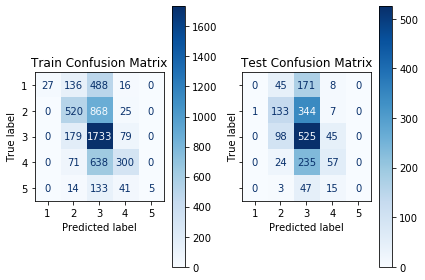

In [32]:
#Fit and predict model and show results
xgbresult = model_fit(X_train, y_train, X_test, y_test, xgb, 'XGBoost')

In [33]:
#Investigate XGB cross validation score 
xgb_mean_cv = cross_val_score(xgb, X, y, cv=3).mean()

print(f"Mean XGboost Cross-Val Score (k=3): {xgb_mean_cv: .2%}")

Mean XGboost Cross-Val Score (k=3):  36.96%


In [34]:
#Look at feature importance for the XGBoost model 
xgb_features = features_df(X_train.columns, xgb.feature_importances_)
xgb_features

,feature,feature_importance
0,decade_2010,0.142653
1,decade_2000,0.059051
2,genre_indie,0.056336
3,genre_dance,0.044852
4,genre_hip hop,0.035590
5,genre_punk,0.033718
6,decade_1980,0.031561
7,instrumentalness,0.031025
8,decade_1970,0.029821
9,genre_pop,0.029442


## 6. Support Vector Machines

In [35]:
#Instansiate the support vecotrs vanilla model
svclassifier = SVC(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           1       1.00      0.01      0.01       667
           2       0.49      0.30      0.37      1413
           3       0.43      0.85      0.57      1991
           4       0.60      0.28      0.38      1009
           5       0.00      0.00      0.00       193

    accuracy                           0.46      5273
   macro avg       0.50      0.29      0.27      5273
weighted avg       0.53      0.46      0.39      5273

Train Set Accuracy: 0.456
Train Set Precision: 0.456
Train Set Recall: 0.456
Train Set F1-Score: 0.456


Test Score Results
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       224
           2       0.46      0.26      0.33       485
           3       0.40      0.80      0.53       668
           4       0.44      0.21      0.29       316
           5       0.00      0.00      0.00        65

    accuracy                           

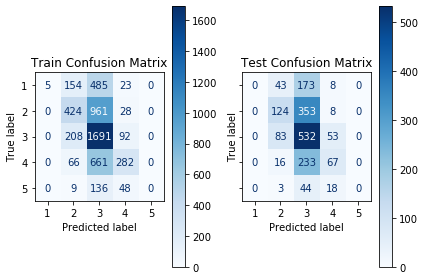

In [36]:
#Fit and predict model and show results. Note we are using the scaled data for the SVM model 
svmresult = model_fit(X_train_scaled, y_train, X_test_scaled, y_test, svclassifier, 'SVM')

## All Vanilla Results

In [37]:
#Create list of all the Vanilla model results 
result_list = [knnresult, bayesresult, decisiontreeresult, baggingresult, 
                randomforestresult, adbresult, xgbresult, svmresult]

In [38]:
#Convert results into a dataframe 
df_results = pd.DataFrame.from_dict(result_list, orient='columns')
df_results = df_results.set_index('model')

In [39]:
#Preview results 
df_results

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,
knn,0.556,0.556,0.556,0.556,0.342,0.342,0.342,0.342
bayes,0.376,0.376,0.376,0.376,0.375,0.375,0.375,0.375
decisiontree,0.995,0.995,0.995,0.995,0.320,0.320,0.320,0.320
bagging,0.994,0.994,0.994,0.994,0.370,0.370,0.370,0.370
randomforest,0.995,0.995,0.995,0.995,0.405,0.405,0.405,0.405
Adaboost,0.407,0.407,0.407,0.407,0.398,0.398,0.398,0.398
XGBoost,0.490,0.490,0.490,0.490,0.407,0.407,0.407,0.407
SVM,0.456,0.456,0.456,0.456,0.411,0.411,0.411,0.411


For this analysis, the goal is to optimize test precision. This is because we do not want any false positives in our model and want to ensure that ratings are classified correctly. Additionally, the model is less sensitive to false negatives, as an incorrect rating of 2 if the actual rating is 3, will not have a significant impact on the interpretability of our model. Therefore, I will further tune XGBoost and SVM models as these models had the highest test precision scores in the vanilla models.

# Section B. Tuning Models

In [40]:
#Preview XGBoost results again 
xgbresult

{'model': 'XGBoost',
 'train_accuracy': 0.49,
 'train_precision': 0.49,
 'train_recall': 0.49,
 'train_f1': 0.49,
 'test_accuracy': 0.407,
 'test_precision': 0.407,
 'test_recall': 0.407,
 'test_f1': 0.407}

In [41]:
#Build parameter grid to be used in GridSearch to find the best hyperparameters
param_grid = {
    'objective': ["multi:softprob"],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'learning_rate': [.1, .15, 1], 
    'subsample': [.6, .8, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100]
}
gs_xgb = GridSearchCV(xgb, param_grid, scoring='precision_micro', cv=3)

In [42]:
#Fit the gridsearch with our X and Y train 
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(objective='multi:softprob'),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.1, 0.15, 1],
                         'n_estimators': [50, 100],
                         'objective': ['multi:softprob'],
                         'subsample': [0.6, 0.8, 1]},
             scoring='precision_micro')

In [43]:
#Display the best possible recall results as well as the best parameters
print(f'Train Precision: {gs_xgb.best_score_}')
xgbtest_precision = precision_score(y_test, gs_xgb.predict(X_test), average='micro')
print(f'Test Precision: {xgbtest_precision}')
print(gs_xgb.best_params_)

Train Precision: 0.40792666594578403
Test Precision: 0.40671217292377704
{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.15, 'n_estimators': 50, 'objective': 'multi:softprob', 'subsample': 0.6}


The test precision score is approx. 0.407, the same result that was given in the baseline model. Next, I will run the mean 3-fold cross validation to see if this score performs any better.

In [44]:
#Investigate XGB cross validation score 
xgb_tuned_mean_cv = cross_val_score(gs_xgb, X, y, cv=3).mean()

print(f"Mean XGboost Cross-Val Score (k=3): {xgb_tuned_mean_cv: .2%}")

Mean XGboost Cross-Val Score (k=3):  38.44%


Next, I will use the predict_proba method to get Predited Probabilities for ratings. By utilizing the probability of obtaining a certain ratings, it allows the actual ratings to take on non-integer values. This will likely reduce the errors that are found between the actual ratings and the future predicted ratings, as the numbers are not restriced to strict integer values. For now I will only collect these predicted ratings, and will later utilize these values in a future recommendation systme.

In [45]:
#Find the probabilities of X (the track ratings)
probs = xgb.predict_proba(X)

#Multiply the probabilties by the values of the ratings (ratings 1-5, respectively)
result = np.array([1,2,3,4,5]) * probs

#Get the final predicted ratings by summing the results across columns 
predictedratings = np.sum(result, axis=1)

In [46]:
#Append these predicted ratings to the X dataframe 
X['predicted ratings'] = predictedratings

In [47]:
#Look at the first 5 rows of the X Dataframe. Notice that predicted ratings is now a new column 
X.head()

,is_explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_hip hop,genre_house,genre_indie,genre_pop,genre_punk,genre_r&b,genre_rap,genre_rock,genre_soul,predicted ratings
0,0,0.638,0.826,8,-4.968,1,0.0479,0.139000,0.000000,0.0803,...,0,0,0,0,0,0,0,0,0,2.908494
1,0,0.791,0.754,0,-3.729,1,0.0569,0.004460,0.000000,0.1630,...,0,0,0,0,0,0,0,0,0,2.973182
2,0,0.649,0.815,3,-3.796,0,0.0415,0.001250,0.000043,0.6710,...,0,0,0,0,0,0,0,0,0,2.753688
3,0,0.699,0.760,5,-3.173,1,0.0677,0.002230,0.000000,0.1320,...,0,0,0,0,0,0,0,0,0,3.171939
4,0,0.678,0.918,5,-4.630,1,0.0355,0.000417,0.000000,0.0744,...,0,0,0,0,0,0,0,0,0,2.890529


In [48]:
#Append the X dataframe to the 'data' dataframe in order to include relevant columns 
df_predictions = pd.concat([X, data[['artist', 'artist_id', 'album', 'track_name','track_id', 'genrecategory']]], axis=1)

In [49]:
#Check columns of our predictions dataframe are all present 
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7031 entries, 0 to 7030
Data columns (total 39 columns):
is_explicit          7031 non-null int64
danceability         7031 non-null float64
energy               7031 non-null float64
key                  7031 non-null int64
loudness             7031 non-null float64
mode                 7031 non-null int64
speechiness          7031 non-null float64
acousticness         7031 non-null float64
instrumentalness     7031 non-null float64
liveness             7031 non-null float64
valence              7031 non-null float64
tempo                7031 non-null float64
duration_ms          7031 non-null int64
decade_1960          7031 non-null int64
decade_1970          7031 non-null int64
decade_1980          7031 non-null int64
decade_1990          7031 non-null int64
decade_2000          7031 non-null int64
decade_2010          7031 non-null int64
genre_acoustic       7031 non-null int64
genre_country        7031 non-null int64
genre_dance   

In [50]:
#Export this predictions dataframe to a separate csv file for future recommendation system models
df_predictions.to_csv('predictionsdf')

### SVM Tuning 

In [51]:
#Define hyperparameters for GridSerach
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'decision_function_shape': ['ovo'],
              'kernel': ['rbf']}  
  
svmgrid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

In [52]:
#Fit the GridSearch model 
svmgrid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.377, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.377, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.3s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_functi

[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.381, total=   1.5s
[CV] C=10, decision_function_shape=ovo, gamma=1, kernel=rbf ..........
[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.387, total=   1.5s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.380, total=   1.5s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.6s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.381, total=   1.5s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.380, total=   1.5s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_sh

[CV]  C=1000, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.387, total=   1.5s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.380, total=   1.6s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.6s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.381, total=   1.5s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.380, total=   1.6s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.388, total=   1.6s
[CV] C=1000, decision_function_shape=ovo, gamma=0.01, kernel=rbf .....
[CV]  C=1000, deci

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  3.2min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo'],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [53]:
#Display the best possible precision results as well as the best parameters
print(f'Train Precision: {svmgrid.best_score_}')
svmtest_precision = precision_score(y_test, svmgrid.predict(X_test), average='weighted')
print(f'Test Precision: {svmtest_precision}')
print(svmgrid.best_params_)

Train Precision: 0.38251535563009786
Test Precision: 0.499481742145342
{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'rbf'}


In [54]:
#Investigate SVM 3-fold cross validation score 
svm_tuned_mean_cv = cross_val_score(svmgrid, X, y, cv=3).mean()

print(f"Mean SVM Cross-Val Score (k=3): {svm_tuned_mean_cv: .2%}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.2s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.0s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.379, total=   1.0s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.0s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.0s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.4s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.4s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.379, total=   1.5s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_functi

[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.375, total=   1.2s
[CV] C=10, decision_function_shape=ovo, gamma=1, kernel=rbf ..........
[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.3s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.373, total=   1.2s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.376, total=   1.2s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.372, total=   1.2s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.375, total=   1.2s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_sh

[CV]  C=1000, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   2.1s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.373, total=   2.6s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.376, total=   2.4s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.372, total=   2.0s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.375, total=   1.8s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.5s
[CV] C=1000, decision_function_shape=ovo, gamma=0.01, kernel=rbf .....
[CV]  C=1000, deci

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.7min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.377, total=   1.0s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.0s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.379, total=   1.8s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.379, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.2s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.2s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_functi

[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.377, total=   1.3s
[CV] C=10, decision_function_shape=ovo, gamma=1, kernel=rbf ..........
[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.379, total=   1.2s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.375, total=   1.8s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.374, total=   1.5s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.376, total=   3.7s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.375, total=   3.7s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_sh

[CV]  C=1000, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.379, total=   1.4s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.375, total=   1.3s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.374, total=   1.5s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.376, total=   1.7s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.375, total=   2.0s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.375, total=   1.8s
[CV] C=1000, decision_function_shape=ovo, gamma=0.01, kernel=rbf .....
[CV]  C=1000, deci

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  3.3min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.2s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.377, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.377, total=   1.4s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.378, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf .........
[CV]  C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.379, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.378, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.1s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.2s
[CV] C=0.1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .......
[CV]  C=0.1, decision_functi

[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.376, total=   1.4s
[CV] C=10, decision_function_shape=ovo, gamma=1, kernel=rbf ..........
[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.376, total=   1.4s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.376, total=   1.4s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.374, total=   1.4s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.374, total=   1.4s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.6s
[CV] C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf ........
[CV]  C=10, decision_function_sh

[CV]  C=1000, decision_function_shape=ovo, gamma=1, kernel=rbf, score=0.376, total=   1.2s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.376, total=   1.2s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.374, total=   1.2s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.374, total=   1.2s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.377, total=   1.2s
[CV] C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf ......
[CV]  C=1000, decision_function_shape=ovo, gamma=0.1, kernel=rbf, score=0.376, total=   1.2s
[CV] C=1000, decision_function_shape=ovo, gamma=0.01, kernel=rbf .....
[CV]  C=1000, deci

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.7min finished


Mean SVM Cross-Val Score (k=3):  37.82%


The test precision results improve slightly compared to the baseline, to approx. 0.499. While this is some increase, it is not a significant improvement (especially since the cross-validation score is only 37.82%). Overall, both the XGBoost and SVM tuned models perform only marginally better. This is likely due to the fact that there are many extraneous factors that could impact a song's popularity, outside of their audio features. For example, the popularity of the artist, how catchy the lyrics are, and how often the song is played on the radio are all features that could impact the popularity of a song. Our model is missing these features, and therefore we are likely not capturing the full impact on popularity, which can explain our model's average results.

### Conclusion

The main purpose of creating a classification model in the context of a recommendation system is to provide a solution for the "cold start problem". If there are new users who come to use our platform who we do not have existing ratings for, we can use their information in our classification model in order to generate predicted ratings. These predicted ratings can be used as a proxy for original ratings, and later on in a recommendation system, we will be able to provide recommendations to these new users. 

In this specific project, the XGBoost model does not perform significantly better once it is tuned with hyperparameters, however I will use this model going forward, due to the probabilistic nature of the ratings' results. Having these probabilistic ratings allows for more exactness in our ratings, and can potentially provide us with less errors when calculating estimated ratings from our future recommendation system.